<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/solution/notebooks/named-entity-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named-Entity-Recognition in TensorFlow 2

This notebook contains code to do Named Entity Reconition in TensorFlow 2.

## Imports and Dependencies

TensorFlow Addons apparently has an implementation of CRF that is compatible with TF2 and tf.keras.

In [1]:
# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow.keras as K
import tensorflow.keras.layers as L

# Python
import os
import string
import re
import random
import time

# Data Structures
import numpy as np
import pandas as pd
import json

# Image/Plotting
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode='Plain', color_scheme='LightBg', tb_offset=1) # Change to 'Verbose' mode for additional debugging

In [7]:
class CharTokenizer:
    """
    Responsible for character tokenizing string input.
    """
    def __init__(self, chars: str = DEFAULT_CHARS, max_seq_size: int = 16):
        """
        Create the tokenizer using the given characters.

        :param chars: The characters that are used in character tokenization as string
        :param max_seq_size: The maximum sequence size used for a character level representation of a word. All words
                             will be padded or truncated to this length.
        """
        self.total_tokens = len(chars) + 2  # +2 to account for 0 (reserved) and 1 (OOV: Out-Of-Vocab)
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.total_tokens, filters='', lower=False,
                                                               char_level=True, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(chars)
        self.max_seq_size = max_seq_size

    def texts_to_sequences(self, texts: str):
        """
        Transform string of texts to character-level tokens. Uses same method as tf.keras.preprocessing.text.Tokenizer.

        :param texts: The text that is to be transformed into character-level tokens.
        :return: The character-level tokens as list of lists
        """
        sequences = self.tokenizer.texts_to_sequences(texts)
        return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=self.max_seq_size, padding='post',
                                                             truncating='post')

    def sequences_to_texts(self, sequences: list):
        """
        Transform sequences of tokenized characters and converts back to its string representation.
        Uses the same method as tf.keras.preprocessing.text.Tokenizer.

        :param sequences: The sequences to be transformed back to a string representation as list of lists
        :return: The converted sequences back in their original string representation as list
        """
        return self.tokenizer.sequences_to_texts(sequences)

In [ ]:
word_tokenizer.split(text)

In [13]:
char_tokenizer = CharTokenizer()
word_tokenizer = Tokenizer(french_words, DEFAULT_NON_PUNCTUATION, DEFAULT_PUNCTUATION)

text = 'The act of death of John Smith'
tokens = word_tokenizer.split(text)

charrep = tf.constant(char_tokenizer.texts_to_sequences(tokens))
wordrep = tf.constant(word_tokenizer.texts_to_sequences(text), shape=(len(tokens), 1))

print(charrep.shape)
print(wordrep.shape)


tf.data.Dataset.from_tensor_slices((wordrep, charrep))

(7, 16)
(7, 1)


<TensorSliceDataset shapes: ((1,), (16,)), types: (tf.int32, tf.int32)>

In [ ]:
t = Tokenizer()

In [6]:
tokenizer = CharTokenizer()
tokenizer.texts_to_sequences(['hello', ',', 'world', '!'])

array([[69, 66, 73, 73, 76,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [84, 76, 79, 73, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

In [2]:
# Note that '!' indicates a shell command rather than python code...

# French NER
# ID: 1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g" -O french_ner_dataset.txt && rm -rf /tmp/cookies.txt

# French Text
# ID: 1M26Gpca8Ug4YvRLxoUDDCjMBeJtojITY
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wDMLz9hTmfvPhkhCHTylbeAU6Utpkqb1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wDMLz9hTmfvPhkhCHTylbeAU6Utpkqb1" -O french_text.txt && rm -rf /tmp/cookies.txt

# Word Embedding Weights
# ID: 1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM" -O french_embedding_weights.npy && rm -rf /tmp/cookies.txt

# char_set.json
!wget -q https://raw.githubusercontent.com/ericburdett/named-entity-recognition/master/char_set.json

## Encoding Class

The encoding class helps us map between strings and indexes.

In [3]:
DEFAULT_CHARS = ' !"#$%&\'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz|~£§¨«¬\xad' \
                '°²´·º»¼½¾ÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿłŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ‒–—†‡‰‹›₂₤℔⅓⅔⅕⅖⅗⅘⅙⅚⅛∆∇∫≠□♀♂✓ｆ'
# The default list of non-punctuation characters needed for the word beam search decoding algorithm
DEFAULT_NON_PUNCTUATION = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿ' \
                          'łŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ'

DEFAULT_PUNCTUATION = string.punctuation + '0123456789'

In [4]:
lines = open('french_text.txt', 'r', encoding='utf8').readlines()

french_words = []
for line in lines:
    french_words.extend(line.split())
french_words = ' '.join(french_words)

In [5]:
class Tokenizer:
    def __init__(self, corpus, word_chars, punctuation, lower=False):
        self.word_chars = word_chars
        self.punctuation = punctuation
        self.regex = r"[" + self.word_chars + r"]+|[^\s]" 

        words = self.split(corpus)
        all_words_list = words + list(punctuation)
        all_words_list_unique = list(set(all_words_list))
        all_words = [' '.join(all_words_list_unique)]

        self.total_tokens = len(all_words_list_unique) + 2 # +2 to account for 0 (reserved) and 1 (OOV)
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.total_tokens, filters='', lower=lower, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(all_words)

    def split(self, text):
        return re.findall(self.regex, text)

    def texts_to_sequences(self, text):
        words = self.split(text)
        return self.tokenizer.texts_to_sequences([' '.join(words)])
    
    def sequences_to_texts(self, sequences):
        return self.tokenizer.sequences_to_texts(sequences)

In [6]:
df = pd.read_csv('french_ner_dataset.txt', sep='\t', names=['word', 'entity', 'id'], header=None)
# df.loc[df['entity'] == 'PrimaryName', 'entity'] = 'Name'

entities = list(set(list(df['entity']))) + ['Start']
print('Possible Entities:', entities)

entity2idx = {}
idx2entity = {}

for index, entity in enumerate(entities):
    entity2idx[entity] = index
    idx2entity[index] = entity

Possible Entities: ['Place', 'Date', 'Name', 'Age', 'none', 'PrimaryName', 'Start']


In [ ]:
df

In [7]:
class Encoder():
  def __init__(self, entity_list, sequence_size=20):
    self.entity_dict = {e: i for i, e in enumerate(entity_list)}
    self.idx_entity_dict = {v: k for k, v in self.entity_dict.items()}
    self.sequence_size = sequence_size

    with open('char_set.json') as file:
      self.char_dict = json.load(file)
    
  def char_to_idx(self, char):
    if char in self.char_dict['char_to_idx']:
      return int(self.char_dict['char_to_idx'][char])
    else:
      return 0
  
  def idx_to_char(self, idx):
    if str(int(idx)) in self.char_dict['idx_to_char']:
      return self.char_dict['idx_to_char'][str(int(idx))]
    else:
      return ''
  
  def str_to_idxs(self, string):
    assert type(string) == str

    zeros = np.zeros(self.sequence_size)
    idxs = []
    for char in string:
      idxs.append(self.char_to_idx(char))
    
    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]

    return idxs
  
  def idxs_to_str(self, idxs):
    chars = ''

    for idx in idxs:
      chars += self.idx_to_char(idx)
    
    return chars
  
  def entity_to_idx(self, entity):
    return self.entity_dict[entity]
  
  def idx_to_entity(self, idx):
    return self.idx_entity_dict[idx]

  def num_classes(self):
    return len(self.entity_dict)

In [7]:
encoder.str_to_idxs('hello')

NameError: ignored

In [8]:
tokenizer.split('hello,')

NameError: ignored

In [8]:
encoder = Encoder(entities, sequence_size=16)
tokenizer = Tokenizer(french_words, DEFAULT_NON_PUNCTUATION, DEFAULT_PUNCTUATION)

data = df.values

sentences = []
sentences_chars = []
labels = []

sentence = []
sentence_chars = []
label = []
current_id = 0
for word, entity, id in data:
    if current_id != id and len(sentence) != 0:

        sentences.append(sentence)
        sentences_chars.append(sentence_chars)
        labels.append(label)

        sentence = []
        sentence_chars = []
        label = []

        current_id = id
        entity = 'Start'

    tokens = tokenizer.texts_to_sequences(word)[0]
    tokens_str = tokenizer.split(word)
    idx = entity2idx[entity]
    for token, token_str in zip(tokens, tokens_str):
        sentence.append(token)
        sentence_chars.append(encoder.str_to_idxs(token_str))
        label.append(idx)

if len(sentence) != 0:
    sentences.append(sentence)
    sentences_chars.append(sentence_chars)
    labels.append(label)

# both = list(zip(sentences, labels))

# random.shuffle(both)
dataset_size = 0
for sentence in sentences:
    for word in sentence:
        dataset_size += 1

sentences = tf.ragged.constant(sentences)
sentences_chars = tf.ragged.constant(sentences_chars)
labels = tf.ragged.constant(labels)

In [9]:
labels.shape

TensorShape([131, None])

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))\
    .shuffle(150, reshuffle_each_iteration=True)\
    .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y, z)))

for word, chars, entity in dataset.take(6):
    print('Word:', word)
    print('Chars:', chars)
    print('Label:', entity)

print('Dataset Size:', dataset_size)

Word: tf.Tensor(9952, shape=(), dtype=int32)
Chars: tf.Tensor([61. 81. 70. 75. 81. 78. 64. 68. 81. 69.  0.  0.  0.  0.  0.  0.], shape=(16,), dtype=float64)
Label: tf.Tensor(6, shape=(), dtype=int32)
Word: tf.Tensor(11504, shape=(), dtype=int32)
Chars: tf.Tensor([79. 69. 84.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.], shape=(16,), dtype=float64)
Label: tf.Tensor(1, shape=(), dtype=int32)
Word: tf.Tensor(8084, shape=(), dtype=int32)
Chars: tf.Tensor([67. 65. 78. 73. 69. 74. 61. 72.  0.  0.  0.  0.  0.  0.  0.  0.], shape=(16,), dtype=float64)
Label: tf.Tensor(1, shape=(), dtype=int32)
Word: tf.Tensor(31879, shape=(), dtype=int32)
Chars: tf.Tensor([72.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.], shape=(16,), dtype=float64)
Label: tf.Tensor(1, shape=(), dtype=int32)
Word: tf.Tensor(38523, shape=(), dtype=int32)
Chars: tf.Tensor([8. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(16,), dtype=float64)
Label: tf.Tensor(1, shape=(), dtype=int32)
Word: tf.Tens

## Model Architecture

This is where we can build our model using the tf.keras high-level API

We subclass from tf.keras.Model and implement the *call* method. This is the *forward pass* of the neural network.

In [11]:
class ConditionalRandomField(K.Model):
    def __init__(self, **kwargs):
        super(ConditionalRandomField, self).__init__(**kwargs)

    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.output_dim = output_dim
        assert(len(input_shape)) == 3
        self.transitions = self.add_weight(
            name="transitions",
            shape=[output_dim, output_dim],
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, x, training=False, **kwargs):
        self.sequence_lengths = tf.reduce_sum(tf.ones_like(x[:,:,0], dtype='int64'), axis=-1)

        if training == False:
            return self.decode(x)
        else:
            return x

    def decode(self, x):
        out, _ = tfa.text.crf_decode(x, self.transitions, self.sequence_lengths)
        out = tf.one_hot(out, x.shape[-1])

        return out

    def loss(self, y_true, y_pred):
        if len(y_true.shape) == 1:
            y_true = tf.expand_dims(y_true, 0)

        if len(y_pred.shape) == 2:
            y_pred = tf.expand_dims(y_pred, 0)

        log_likelihood, self.transitions = tfa.text.crf_log_likelihood(
            y_pred,
            y_true,
            self.sequence_lengths,
            transition_params=self.transitions
        )
        return tf.reduce_mean(-log_likelihood)

    def compute_output_shape(self, input_shape):
        return input_shape[:2] + (self.out_dim,)

    def accuracy(self, y_true, y_pred):
        y_pred, _ = tfa.text.crf_decode(
            y_pred, self.transitions, self.sequence_lengths
        )
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        is_equal = tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32)

        return tf.reduce_mean(is_equal)

In [12]:
crf = ConditionalRandomField()

preds = tf.squeeze(crf(tf.constant(np.random.randn(1, 10, 6), dtype=tf.float32), training=True), 0)
crf.loss(tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), preds)

InvalidArgumentError: ignored

In [14]:
reg = tf.keras.regularizers.L2(l2=0.00)

class NERModel(K.Model):
  def __init__(self, word_input_dim=25_000, word_output_dim=128, char_input_dim=197, char_output_dim=128, num_classes=8, embedding_weights=None, word_trainable=True):
    super(NERModel, self).__init__()

    self.word_embedding = L.Embedding(input_dim=word_input_dim, output_dim=char_output_dim, mask_zero=True, trainable=word_trainable, weights=embedding_weights)
    self.char_embedding = L.Embedding(input_dim=char_input_dim, output_dim=char_output_dim, mask_zero=True, trainable=True)

    self.char_conv1 = L.Conv1D(64, 3, padding='same')
    self.bn1 = L.BatchNormalization()
    self.relu1 = L.ReLU()
    self.char_conv2 = L.Conv1D(64, 3, padding='same')
    self.bn2 = L.BatchNormalization()
    self.relu2 = L.ReLU()
    self.mp1 = L.MaxPooling1D()
    self.char_conv3 = L.Conv1D(96, 3, padding='same')
    self.bn3 = L.BatchNormalization()
    self.relu3 = L.ReLU()
    self.mp2 = L.MaxPooling1D()
    self.char_conv4 = L.Conv1D(96, 3, padding='same')
    self.bn4 = L.BatchNormalization()
    self.relu4 = L.ReLU()
    self.mp3 = L.MaxPooling1D()
    self.char_conv5 = L.Conv1D(128, 3, padding='same')
    self.bn5 = L.BatchNormalization()
    self.relu5 = L.ReLU()
    self.mp4 = L.MaxPooling1D()

    self.gru1 = L.Bidirectional(L.GRU(128, return_sequences=True, stateful=True, dropout=0.5, kernel_regularizer=reg, batch_input_shape=(1, None)))
    self.gru2 = L.Bidirectional(L.GRU(128, return_sequences=True, stateful=True, dropout=0.5, kernel_regularizer=reg, batch_input_shape=(1, None)))

    self.dense = L.Dense(num_classes, kernel_regularizer=reg)
    # self.crf = ConditionalRandomField()

  def __call__(self, x_word, x_char, training=False, **kwargs):
    word_out = self.word_embedding(x_word)
    word_out = tf.expand_dims(word_out, 0)

    char_out = self.char_embedding(x_char)

    char_out = self.char_conv1(char_out)
    char_out = self.bn1(char_out)
    char_out = self.relu1(char_out)
    char_out = self.char_conv2(char_out)
    char_out = self.bn2(char_out)
    char_out = self.relu2(char_out)
    char_out = self.mp1(char_out)
    char_out = self.char_conv3(char_out)
    char_out = self.bn3(char_out)
    char_out = self.relu3(char_out)
    char_out = self.mp2(char_out)
    char_out = self.char_conv4(char_out)
    char_out = self.bn4(char_out)
    char_out = self.relu4(char_out)   
    char_out = self.mp3(char_out)
    char_out = self.char_conv5(char_out)
    char_out = self.bn5(char_out)
    char_out = self.relu5(char_out)   
    char_out = self.mp4(char_out)
    char_out = tf.transpose(char_out, perm=[1, 0, 2])

    out = tf.concat((word_out, char_out), axis=2)

    out = self.gru1(out)
    out = self.gru2(out)

    out = self.dense(out)
    # out = self.crf(out, training=training)

    out = tf.squeeze(out, 0)

    return out

### Test to make sure the model is doing what we think it is...

The output shape should be (NUM_WORDS_IN_SENTENCE, NUM_CLASSES). Example: (41, 6)

The values along Axis=0 represents a word

The values along Axis=1 represents the probability distribution

In [15]:
pretrained_embedding_weights = np.load('french_embedding_weights.npy')

dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))\
    .shuffle(150, reshuffle_each_iteration=True)\
    .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))

model = NERModel(word_input_dim=tokenizer.total_tokens, char_input_dim=len(encoder.char_dict['idx_to_char']) + 1, num_classes=len(entity2idx), word_trainable=True)

for word, chars, entity in dataset.batch(5).take(1):
    results = model(word, chars, training=True)
    print('Shape of output from NER Model: ', results.shape)
    print('Probability Distribution for one word in the sentence: ', results[0])
    print('Predicted class for the word: ', tf.argmax(results[0]).numpy())

Shape of output from NER Model:  (5, 7)
Probability Distribution for one word in the sentence:  tf.Tensor(
[-9.8818709e-06  9.3292389e-03 -1.8062301e-03 -9.8573016e-03
 -3.8435091e-03 -1.9900624e-02 -5.8704931e-03], shape=(7,), dtype=float32)
Predicted class for the word:  1


## Evaluation Metrics

For named-entity-recognition, we will use Precision, Recall, and F1 for our
metrics. An easy way to do this is using sklearn metrics. We need to define
custom functions so that we can pass the *average* parameter when it's wrapped
in a *tf.py_function*.

In [16]:
def precision_score(y_true, y_pred):
  return metrics.precision_score(y_true, y_pred, average='macro')

def recall_score(y_true, y_pred):
  return metrics.recall_score(y_true, y_pred, average='macro')

def f1_score(y_true, y_pred):
  return metrics.f1_score(y_true, y_pred, average='macro')

## Training Loop

Build our training loop and creating custom train_step and val_step functions.

GradientTape allows us to keep track of the losses and gradients for each pass through the network. Structuring our code this way makes it much easier for debugging purposes and for us to iterate through our design.

Notice the decorator *@tf.function*. This tells TensorFlow to create the computation graph from the python code and allows our model to run much faster. The *experimental_relax_shapes* parameter allows us to pass tensors with various sentence lengths without TensorFlow getting upset at us.

TensorFlow 2 also does some weird things with scope when it constructs the computation graph through a @tf.function annotation. Thus, if we use a more object oriented approach, we can avoid some of the nasty scope issues. See the following articles for more details:
* https://pgaleone.eu/tensorflow/tf.function/2019/03/21/dissecting-tf-function-part-1/
* https://pgaleone.eu/tensorflow/tf.function/2019/04/03/dissecting-tf-function-part-2/


In [18]:
class Train:
    def __init__(self):
        # How many times through the training set should we go?
        self.epochs = 400
        self.batch_size = 128
        self.num_classes = len(idx2entity)

        # Break up dataset into training/validation
        dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))
        dataset_size = dataset.cardinality().numpy()
        self.train_dataset_size = int(dataset_size * 0.8)
        self.val_dataset_size = dataset_size - self.train_dataset_size

        self.train_dataset = dataset.take(self.train_dataset_size)\
            .shuffle(self.train_dataset_size, reshuffle_each_iteration=True)\
            .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))\
            .batch(self.batch_size, drop_remainder=False)
        self.val_dataset = dataset.skip(self.train_dataset_size)\
            .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))\
            .batch(self.batch_size, drop_remainder=False)

        self.train_dataset_size = 0
        for _, _, _ in self.train_dataset:
            self.train_dataset_size += 1

        self.val_dataset_size = 0
        for _, _, _ in self.val_dataset:
            self.val_dataset_size += 1

        embedding_weights = [np.load('french_embedding_weights.npy')]

        # Create our model
        self.model = NERModel(word_input_dim=tokenizer.total_tokens,
                              char_input_dim=len(encoder.char_dict['idx_to_char']) + 1,
                              num_classes=self.num_classes,
                              embedding_weights=embedding_weights,
                              word_trainable=False)

        # Use CrossEntropy for our loss function and Adam for our optimizer
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
        # self.loss_fn = self.model.crf.loss
        self.optimizer = K.optimizers.Adam(learning_rate=2e-4)

        # Metrics to track our performance
        self.train_pred_loss = tf.keras.metrics.Mean(name='train_pred_loss')
        self.train_reg_loss = tf.keras.metrics.Mean(name='train_reg_loss')
        self.val_pred_loss = tf.keras.metrics.Mean(name='val_pred_loss')
        self.val_reg_loss = tf.keras.metrics.Mean(name='val_reg_loss')

    @tf.function(experimental_relax_shapes=True)
    def train_step(self, words, chars, labels):
        with tf.GradientTape() as tape:
            # Make a prediction, calculate the loss
            predictions = self.model(words, chars, training=True)
            # pred_loss = self.loss_fn(labels, predictions)
            pred_loss = self.loss_fn(tf.one_hot(labels, self.num_classes), predictions)
            reg_loss = tf.reduce_sum(self.model.losses)
            loss = pred_loss + reg_loss

        # Obtain gradients from GradientTape
        gradients = tape.gradient(loss, self.model.trainable_variables)

        # Propagate loss back through the network and take a step with the optimizer  
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_pred_loss(pred_loss)
        self.train_reg_loss(reg_loss)

        return predictions

    @tf.function(experimental_relax_shapes=True)
    def validation_step(self, words, chars, labels):
        # Make a prediction and calculate the loss
        predictions = self.model(words, chars, training=False)
        # pred_loss = self.loss_fn(labels, predictions)
        pred_loss = self.loss_fn(tf.one_hot(labels, self.num_classes), predictions)
        reg_loss = tf.reduce_sum(self.model.losses)
        loss = pred_loss + reg_loss

        self.val_pred_loss(pred_loss)
        self.val_reg_loss(reg_loss)

        return predictions

    def __call__(self):
        # Variables to keep track of our progress through the entire training process
        # Used below when we create our graphs
        try:
            train_losses, val_losses = [], []
            train_precisions, val_precisions = [], []
            train_recalls, val_recalls = [], []
            train_f1s, val_f1s = [], []

            for epoch in range(self.epochs):
                # Reset Metrics for another epoch
                self.train_pred_loss.reset_states()
                self.train_reg_loss.reset_states()
                self.val_pred_loss.reset_states()
                self.val_reg_loss.reset_states()

                # Training Loop
                y_pred = []
                y_true = []
                train_loop = tqdm(total=self.train_dataset_size, position=0, leave=True)
                for words, chars, labels in self.train_dataset:
                    # One training iteration
                    output = self.train_step(words, chars, labels)

                    predictions = tf.argmax(output, 1)
                    y_pred.extend(predictions.numpy())
                    y_true.extend(labels.numpy())

                    train_loop.set_description('Train - Epoch: {}, PredLoss: {:.4f}, RegLoss: {:.4f}'.format(
                    epoch, self.train_pred_loss.result(), self.train_reg_loss.result()))
                    train_loop.update(1)
                train_loop.close()

                precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
                print('Train - Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(precision, recall, f1))
                time.sleep(0.5)

                train_losses.append(self.train_pred_loss.result() + self.train_reg_loss.result())
                train_precisions.append(precision)
                train_recalls.append(recall)
                train_f1s.append(f1)

                self.model.reset_states()

                # Validation Loop
                y_pred = []
                y_true = []
                val_loop = tqdm(total=self.val_dataset_size, position=0, leave=True)
                for words, chars, labels in self.val_dataset:
                    # One validation iteration
                    output = self.validation_step(words, chars, labels)
                    predictions = tf.argmax(output, 1)

                    y_pred.extend(predictions.numpy())
                    y_true.extend(labels.numpy()) 

                    val_loop.set_description('Val  - Epoch: {}, PredLoss: {:.4f}, RegLoss: {:.4f}'.format(
                    epoch, self.val_pred_loss.result(), self.val_reg_loss.result()))
                    val_loop.update(1)
                val_loop.close()

                self.model.reset_states()

                precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
                print('Val   - Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(precision, recall, f1))
                time.sleep(0.5)

                val_losses.append(self.val_pred_loss.result() + self.val_reg_loss.result())
                val_precisions.append(precision)
                val_recalls.append(recall)
                val_f1s.append(f1)

        except:
            __ITB__()
        finally:
            return self.model, (train_losses, val_losses), (train_precisions, val_precisions), (train_recalls, val_recalls), (train_f1s, val_f1s)

In [19]:
try:
  train = Train()
  model, losses, precisions, recalls, f1s = train()
except:
  __ITB__()

Train - Epoch: 0, PredLoss: 1.0764, RegLoss: 0.0000: 100%|██████████| 115/115 [00:34<00:00,  3.37it/s]


Train - Precision: 0.6319, Recall: 0.3455, F1: 0.4060


Val  - Epoch: 0, PredLoss: 0.8409, RegLoss: 0.0000: 100%|██████████| 34/34 [00:03<00:00, 11.10it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val   - Precision: 0.7583, Recall: 0.5359, F1: 0.5826


Train - Epoch: 1, PredLoss: 0.7357, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.14it/s]


Train - Precision: 0.9250, Recall: 0.6890, F1: 0.7254


Val  - Epoch: 1, PredLoss: 0.7612, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.06it/s]


Val   - Precision: 0.9157, Recall: 0.6762, F1: 0.7350


Train - Epoch: 2, PredLoss: 0.6509, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.26it/s]


Train - Precision: 0.9482, Recall: 0.8025, F1: 0.8493


Val  - Epoch: 2, PredLoss: 0.7188, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.34it/s]


Val   - Precision: 0.8930, Recall: 0.7715, F1: 0.8192


Train - Epoch: 3, PredLoss: 0.5995, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.22it/s]


Train - Precision: 0.9544, Recall: 0.8975, F1: 0.9233


Val  - Epoch: 3, PredLoss: 0.6851, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.66it/s]


Val   - Precision: 0.9027, Recall: 0.8075, F1: 0.8465


Train - Epoch: 4, PredLoss: 0.5641, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.16it/s]


Train - Precision: 0.9669, Recall: 0.9383, F1: 0.9522


Val  - Epoch: 4, PredLoss: 0.6678, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.29it/s]


Val   - Precision: 0.9103, Recall: 0.8051, F1: 0.8483


Train - Epoch: 5, PredLoss: 0.5505, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.21it/s]


Train - Precision: 0.9656, Recall: 0.9485, F1: 0.9569


Val  - Epoch: 5, PredLoss: 0.6515, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.27it/s]


Val   - Precision: 0.9133, Recall: 0.8164, F1: 0.8567


Train - Epoch: 6, PredLoss: 0.5368, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.29it/s]


Train - Precision: 0.9735, Recall: 0.9606, F1: 0.9669


Val  - Epoch: 6, PredLoss: 0.6445, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.55it/s]


Val   - Precision: 0.9118, Recall: 0.8337, F1: 0.8673


Train - Epoch: 7, PredLoss: 0.5249, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.27it/s]


Train - Precision: 0.9766, Recall: 0.9684, F1: 0.9724


Val  - Epoch: 7, PredLoss: 0.6412, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.35it/s]


Val   - Precision: 0.9230, Recall: 0.8223, F1: 0.8646


Train - Epoch: 8, PredLoss: 0.5178, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.26it/s]


Train - Precision: 0.9794, Recall: 0.9709, F1: 0.9750


Val  - Epoch: 8, PredLoss: 0.6401, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.22it/s]


Val   - Precision: 0.9143, Recall: 0.8484, F1: 0.8754


Train - Epoch: 9, PredLoss: 0.5093, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.23it/s]


Train - Precision: 0.9817, Recall: 0.9742, F1: 0.9779


Val  - Epoch: 9, PredLoss: 0.6532, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.38it/s]


Val   - Precision: 0.9264, Recall: 0.7905, F1: 0.8470


Train - Epoch: 10, PredLoss: 0.5026, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.31it/s]


Train - Precision: 0.9837, Recall: 0.9788, F1: 0.9811


Val  - Epoch: 10, PredLoss: 0.6222, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.34it/s]


Val   - Precision: 0.9224, Recall: 0.8440, F1: 0.8779


Train - Epoch: 11, PredLoss: 0.4993, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.13it/s]


Train - Precision: 0.9843, Recall: 0.9783, F1: 0.9812


Val  - Epoch: 11, PredLoss: 0.6193, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.05it/s]


Val   - Precision: 0.9211, Recall: 0.8309, F1: 0.8708


Train - Epoch: 12, PredLoss: 0.4928, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.22it/s]


Train - Precision: 0.9874, Recall: 0.9816, F1: 0.9844


Val  - Epoch: 12, PredLoss: 0.6239, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.39it/s]


Val   - Precision: 0.9212, Recall: 0.8360, F1: 0.8745


Train - Epoch: 13, PredLoss: 0.4881, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.19it/s]


Train - Precision: 0.9876, Recall: 0.9826, F1: 0.9850


Val  - Epoch: 13, PredLoss: 0.6205, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.12it/s]


Val   - Precision: 0.9163, Recall: 0.8439, F1: 0.8769


Train - Epoch: 14, PredLoss: 0.4838, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.24it/s]


Train - Precision: 0.9893, Recall: 0.9814, F1: 0.9853


Val  - Epoch: 14, PredLoss: 0.6110, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.01it/s]


Val   - Precision: 0.9268, Recall: 0.8463, F1: 0.8818


Train - Epoch: 15, PredLoss: 0.4805, RegLoss: 0.0000: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s]


Train - Precision: 0.9905, Recall: 0.9860, F1: 0.9882


Val  - Epoch: 15, PredLoss: 0.6152, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.90it/s]


Val   - Precision: 0.9180, Recall: 0.8516, F1: 0.8814


Train - Epoch: 16, PredLoss: 0.4765, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.25it/s]


Train - Precision: 0.9899, Recall: 0.9866, F1: 0.9882


Val  - Epoch: 16, PredLoss: 0.6098, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 21.80it/s]


Val   - Precision: 0.9237, Recall: 0.8387, F1: 0.8760


Train - Epoch: 17, PredLoss: 0.4731, RegLoss: 0.0000: 100%|██████████| 115/115 [00:28<00:00,  4.10it/s]


Train - Precision: 0.9914, Recall: 0.9912, F1: 0.9913


Val  - Epoch: 17, PredLoss: 0.6059, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.52it/s]


Val   - Precision: 0.9465, Recall: 0.8440, F1: 0.8885


Train - Epoch: 18, PredLoss: 0.4706, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.24it/s]


Train - Precision: 0.9936, Recall: 0.9903, F1: 0.9919


Val  - Epoch: 18, PredLoss: 0.6043, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.84it/s]


Val   - Precision: 0.9312, Recall: 0.8389, F1: 0.8795


Train - Epoch: 19, PredLoss: 0.4691, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.19it/s]


Train - Precision: 0.9928, Recall: 0.9896, F1: 0.9911


Val  - Epoch: 19, PredLoss: 0.6019, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.93it/s]


Val   - Precision: 0.9159, Recall: 0.8754, F1: 0.8933


Train - Epoch: 20, PredLoss: 0.4679, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.30it/s]


Train - Precision: 0.9932, Recall: 0.9906, F1: 0.9918


Val  - Epoch: 20, PredLoss: 0.6013, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.24it/s]


Val   - Precision: 0.9164, Recall: 0.8503, F1: 0.8806


Train - Epoch: 21, PredLoss: 0.4660, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.16it/s]


Train - Precision: 0.9934, Recall: 0.9913, F1: 0.9923


Val  - Epoch: 21, PredLoss: 0.6017, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.15it/s]


Val   - Precision: 0.9318, Recall: 0.8449, F1: 0.8844


Train - Epoch: 22, PredLoss: 0.4640, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.14it/s]


Train - Precision: 0.9944, Recall: 0.9937, F1: 0.9940


Val  - Epoch: 22, PredLoss: 0.5974, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.78it/s]


Val   - Precision: 0.9409, Recall: 0.8497, F1: 0.8907


Train - Epoch: 23, PredLoss: 0.4615, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.25it/s]


Train - Precision: 0.9952, Recall: 0.9962, F1: 0.9957


Val  - Epoch: 23, PredLoss: 0.5948, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 21.83it/s]


Val   - Precision: 0.9185, Recall: 0.8621, F1: 0.8879


Train - Epoch: 24, PredLoss: 0.4614, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.30it/s]


Train - Precision: 0.9944, Recall: 0.9949, F1: 0.9946


Val  - Epoch: 24, PredLoss: 0.6018, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.29it/s]


Val   - Precision: 0.9357, Recall: 0.8520, F1: 0.8906


Train - Epoch: 25, PredLoss: 0.4597, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.28it/s]


Train - Precision: 0.9945, Recall: 0.9951, F1: 0.9948


Val  - Epoch: 25, PredLoss: 0.5901, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.63it/s]


Val   - Precision: 0.9473, Recall: 0.8549, F1: 0.8943


Train - Epoch: 26, PredLoss: 0.4588, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.31it/s]


Train - Precision: 0.9959, Recall: 0.9958, F1: 0.9959


Val  - Epoch: 26, PredLoss: 0.6001, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.00it/s]


Val   - Precision: 0.9425, Recall: 0.8551, F1: 0.8945


Train - Epoch: 27, PredLoss: 0.4591, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.34it/s]


Train - Precision: 0.9971, Recall: 0.9956, F1: 0.9964


Val  - Epoch: 27, PredLoss: 0.5946, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.56it/s]


Val   - Precision: 0.9302, Recall: 0.8753, F1: 0.9012


Train - Epoch: 28, PredLoss: 0.4578, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.32it/s]


Train - Precision: 0.9962, Recall: 0.9962, F1: 0.9962


Val  - Epoch: 28, PredLoss: 0.5948, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.35it/s]


Val   - Precision: 0.9402, Recall: 0.8546, F1: 0.8932


Train - Epoch: 29, PredLoss: 0.4563, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.33it/s]


Train - Precision: 0.9958, Recall: 0.9950, F1: 0.9954


Val  - Epoch: 29, PredLoss: 0.6003, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.20it/s]


Val   - Precision: 0.9217, Recall: 0.8782, F1: 0.8983


Train - Epoch: 30, PredLoss: 0.4563, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.30it/s]


Train - Precision: 0.9956, Recall: 0.9950, F1: 0.9953


Val  - Epoch: 30, PredLoss: 0.5924, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.64it/s]


Val   - Precision: 0.9369, Recall: 0.8743, F1: 0.9019


Train - Epoch: 31, PredLoss: 0.4555, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.31it/s]


Train - Precision: 0.9975, Recall: 0.9970, F1: 0.9973


Val  - Epoch: 31, PredLoss: 0.6047, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.49it/s]


Val   - Precision: 0.9349, Recall: 0.8634, F1: 0.8945


Train - Epoch: 32, PredLoss: 0.4548, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.25it/s]


Train - Precision: 0.9965, Recall: 0.9968, F1: 0.9967


Val  - Epoch: 32, PredLoss: 0.5918, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.28it/s]


Val   - Precision: 0.9131, Recall: 0.8808, F1: 0.8953


Train - Epoch: 33, PredLoss: 0.4542, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.34it/s]


Train - Precision: 0.9982, Recall: 0.9967, F1: 0.9974


Val  - Epoch: 33, PredLoss: 0.6254, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.80it/s]


Val   - Precision: 0.9363, Recall: 0.8487, F1: 0.8888


Train - Epoch: 34, PredLoss: 0.4582, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.34it/s]


Train - Precision: 0.9953, Recall: 0.9961, F1: 0.9957


Val  - Epoch: 34, PredLoss: 0.5997, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.00it/s]


Val   - Precision: 0.9452, Recall: 0.8516, F1: 0.8921


Train - Epoch: 35, PredLoss: 0.4550, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.31it/s]


Train - Precision: 0.9962, Recall: 0.9979, F1: 0.9970


Val  - Epoch: 35, PredLoss: 0.5985, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 21.73it/s]


Val   - Precision: 0.9423, Recall: 0.8588, F1: 0.8960


Train - Epoch: 36, PredLoss: 0.4528, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.25it/s]


Train - Precision: 0.9969, Recall: 0.9968, F1: 0.9968


Val  - Epoch: 36, PredLoss: 0.5998, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.10it/s]


Val   - Precision: 0.9340, Recall: 0.8732, F1: 0.9003


Train - Epoch: 37, PredLoss: 0.4529, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.27it/s]


Train - Precision: 0.9964, Recall: 0.9967, F1: 0.9965


Val  - Epoch: 37, PredLoss: 0.5916, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.09it/s]


Val   - Precision: 0.9430, Recall: 0.8690, F1: 0.9025


Train - Epoch: 38, PredLoss: 0.4519, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.26it/s]


Train - Precision: 0.9968, Recall: 0.9972, F1: 0.9970


Val  - Epoch: 38, PredLoss: 0.5916, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.32it/s]


Val   - Precision: 0.9397, Recall: 0.8724, F1: 0.9023


Train - Epoch: 39, PredLoss: 0.4515, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.28it/s]


Train - Precision: 0.9990, Recall: 0.9965, F1: 0.9978


Val  - Epoch: 39, PredLoss: 0.5918, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.79it/s]


Val   - Precision: 0.9125, Recall: 0.8961, F1: 0.9026


Train - Epoch: 40, PredLoss: 0.4525, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.28it/s]


Train - Precision: 0.9964, Recall: 0.9980, F1: 0.9972


Val  - Epoch: 40, PredLoss: 0.5854, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.87it/s]


Val   - Precision: 0.9417, Recall: 0.8832, F1: 0.9102


Train - Epoch: 41, PredLoss: 0.4517, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.30it/s]


Train - Precision: 0.9991, Recall: 0.9963, F1: 0.9976


Val  - Epoch: 41, PredLoss: 0.5860, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.18it/s]


Val   - Precision: 0.9389, Recall: 0.8759, F1: 0.9051


Train - Epoch: 42, PredLoss: 0.4516, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.30it/s]


Train - Precision: 0.9969, Recall: 0.9967, F1: 0.9968


Val  - Epoch: 42, PredLoss: 0.5790, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.90it/s]


Val   - Precision: 0.9347, Recall: 0.8888, F1: 0.9089


Train - Epoch: 43, PredLoss: 0.4589, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.13it/s]


Train - Precision: 0.9952, Recall: 0.9936, F1: 0.9944


Val  - Epoch: 43, PredLoss: 0.6031, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.93it/s]


Val   - Precision: 0.9321, Recall: 0.8455, F1: 0.8840


Train - Epoch: 44, PredLoss: 0.4541, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.27it/s]


Train - Precision: 0.9966, Recall: 0.9960, F1: 0.9963


Val  - Epoch: 44, PredLoss: 0.6046, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 22.55it/s]


Val   - Precision: 0.9203, Recall: 0.8740, F1: 0.8950


Train - Epoch: 45, PredLoss: 0.4510, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.26it/s]


Train - Precision: 0.9974, Recall: 0.9977, F1: 0.9976


Val  - Epoch: 45, PredLoss: 0.5995, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.22it/s]


Val   - Precision: 0.9155, Recall: 0.8787, F1: 0.8955


Train - Epoch: 46, PredLoss: 0.4509, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.26it/s]


Train - Precision: 0.9973, Recall: 0.9989, F1: 0.9981


Val  - Epoch: 46, PredLoss: 0.5977, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.20it/s]


Val   - Precision: 0.9361, Recall: 0.8704, F1: 0.8998


Train - Epoch: 47, PredLoss: 0.4504, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.24it/s]


Train - Precision: 0.9992, Recall: 0.9968, F1: 0.9980


Val  - Epoch: 47, PredLoss: 0.5982, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.21it/s]


Val   - Precision: 0.9102, Recall: 0.8926, F1: 0.8999


Train - Epoch: 48, PredLoss: 0.4501, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.24it/s]


Train - Precision: 0.9976, Recall: 0.9976, F1: 0.9976


Val  - Epoch: 48, PredLoss: 0.5959, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.75it/s]


Val   - Precision: 0.9255, Recall: 0.8793, F1: 0.9005


Train - Epoch: 49, PredLoss: 0.4502, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.28it/s]


Train - Precision: 0.9974, Recall: 0.9972, F1: 0.9973


Val  - Epoch: 49, PredLoss: 0.5983, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.45it/s]


Val   - Precision: 0.9277, Recall: 0.8731, F1: 0.8984


Train - Epoch: 50, PredLoss: 0.4500, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.21it/s]


Train - Precision: 0.9974, Recall: 0.9975, F1: 0.9974


Val  - Epoch: 50, PredLoss: 0.5952, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 21.80it/s]


Val   - Precision: 0.9292, Recall: 0.8767, F1: 0.9008


Train - Epoch: 51, PredLoss: 0.4516, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.28it/s]


Train - Precision: 0.9972, Recall: 0.9970, F1: 0.9971


Val  - Epoch: 51, PredLoss: 0.6156, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.70it/s]


Val   - Precision: 0.9543, Recall: 0.8466, F1: 0.8933


Train - Epoch: 52, PredLoss: 0.4497, RegLoss: 0.0000:  12%|█▏        | 14/115 [00:03<00:24,  4.18it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 807, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 2829, in __call__
    return graph_function._filtered_call(args, kwargs)  # pylint: disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 1848, in _filtered_call
    cancellation_manager=cancellation_manager)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 1924, in _call_flat
    ctx, args, cancellation_manager=cancellation_manager))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 550, in cal

Train - Epoch: 52, PredLoss: 0.4497, RegLoss: 0.0000:  12%|█▏        | 14/115 [00:03<00:25,  3.92it/s]


## Results

Show how our model did throughout the training process.

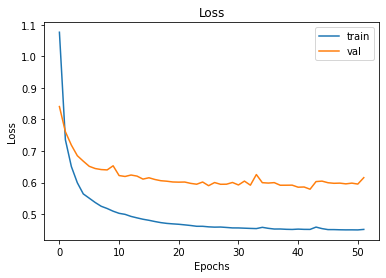

Final Validation Loss: 0.6156


In [20]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses[0], label='train')
plt.plot(losses[1], label='val')
plt.legend()
plt.show()
print('Final Validation Loss: {:.4f}'.format(losses[1][-1]))

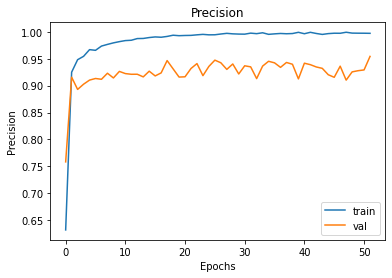

Final Validation Precision: 95.43%


In [21]:
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(precisions[0], label='train')
plt.plot(precisions[1], label='val')
plt.legend()
plt.show()
print('Final Validation Precision: {:.2f}%'.format(precisions[1][-1] * 100))

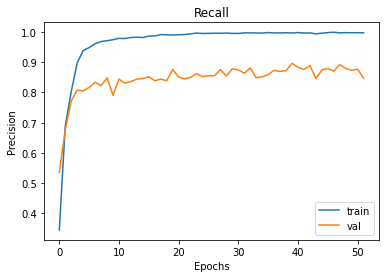

Final Validation Recall: 84.66%


In [22]:
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(recalls[0], label='train')
plt.plot(recalls[1], label='val')
plt.legend()
plt.show()
print('Final Validation Recall: {:.2f}%'.format(recalls[1][-1] * 100))

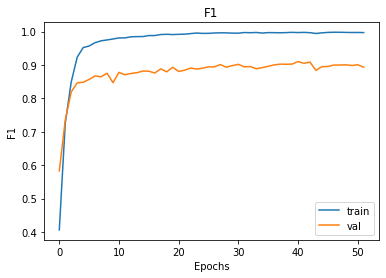

Final Validation F1: 89.33%


In [23]:
plt.title('F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.plot(f1s[0], label='train')
plt.plot(f1s[1], label='val')
plt.legend()
plt.show()
print('Final Validation F1: {:.2f}%'.format(f1s[1][-1] * 100))

## Examples and Confusion Matrix

* Show the final confusion matrix on the validation set.
* Show a couple examples of the model classifying text.

In [24]:
sentence_size = 200

batch_size = 200

dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))

dataset_size = dataset.cardinality().numpy()
train_dataset_size = int(dataset_size * 0.8)
val_dataset_size = dataset_size - train_dataset_size

val_dataset = dataset.skip(train_dataset_size)\
    .shuffle(150, reshuffle_each_iteration=True)\
    .take(sentence_size)\
    .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))\
    .batch(batch_size)

y_true = []
y_pred = []

for index, (word, char, label) in enumerate(val_dataset):
    output = model(word, char, training=False)
    prediction = tf.squeeze(tf.argmax(output, 1)).numpy()
    y_pred.extend(prediction)
    label = tf.squeeze(label).numpy()
    y_true.extend(label)

    word = np.expand_dims(word.numpy(), 1)
    str_words = tokenizer.sequences_to_texts(word)

    for word, pred, actual in zip(str_words, prediction, label):
        pred = idx2entity[pred]
        actual = idx2entity[actual]
        print('Word: {} - Prediction: {} - Actual: {}'.format(word, pred, actual))

Word: Le - Prediction: none - Actual: Start
Word: deux - Prediction: none - Actual: Date
Word: décembre - Prediction: none - Actual: Date
Word: mil - Prediction: none - Actual: Date
Word: neuf - Prediction: none - Actual: Date
Word: treize - Prediction: none - Actual: Date
Word: à - Prediction: none - Actual: none
Word: midi - Prediction: none - Actual: none
Word: , - Prediction: none - Actual: none
Word: <OOV> - Prediction: Name - Actual: PrimaryName
Word: Joseph - Prediction: Name - Actual: PrimaryName
Word: , - Prediction: Name - Actual: PrimaryName
Word: cafetier - Prediction: none - Actual: none
Word: , - Prediction: none - Actual: none
Word: né - Prediction: none - Actual: none
Word: à - Prediction: none - Actual: none
Word: <OOV> - Prediction: Place - Actual: Place
Word: ( - Prediction: Place - Actual: Place
Word: Isere - Prediction: Place - Actual: Place
Word: ) - Prediction: Place - Actual: Place
Word: le - Prediction: none - Actual: none
Word: vingt - Prediction: Date - Actua

Use sklearn to create the confusion matrix from the actual/predicted values

In [25]:
def classification_report(y_true, y_pred, labels):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)

    print('|{:^15}|{:^12}|{:^12}|{:^12}|{:^12}|'.format('Class Label', 'Precision', 'Recall', 'F1', 'Support'))

    for p, r, f, s, label in zip(precision, recall, f1, support, labels):
        print('{:-<69}'.format(''))
        print('|{:^15}|{:^12.4f}|{:^12.4f}|{:^12.4f}|{:^12}|'.format(label, p, r, f, s))
    print('{:-<69}'.format(''))
    print('|{:^15}|{:^12.4f}|{:^12.4f}|{:^12.4f}|{:^12}|'.format('TOTAL', np.mean(precision), np.mean(recall), np.mean(f1), ''))
    print('{:-<69}'.format(''))


Print the Heatmap and convert the index class labels back to their original
text representation.

Text(123.0, 0.5, 'Actual')

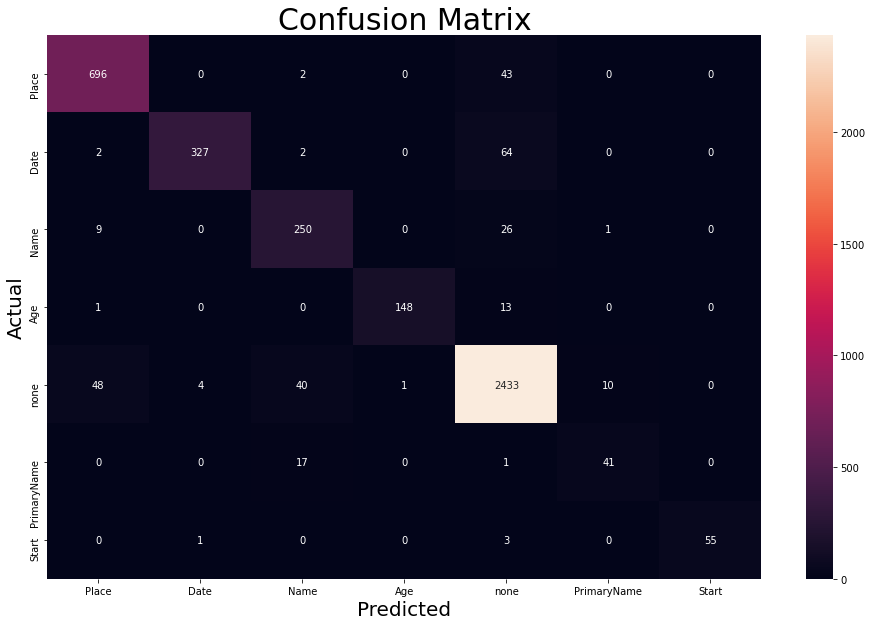

In [26]:
matrix = metrics.confusion_matrix(y_true, y_pred)

class_labels = [e for e in entity2idx]

plt.figure(figsize = (16, 10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix', fontdict={'fontsize': 30})
plt.xlabel('Predicted', fontdict={'fontsize': 20})
plt.ylabel('Actual', fontdict={'fontsize': 20})

In [27]:
classification_report(y_true, y_pred, class_labels)

|  Class Label  | Precision  |   Recall   |     F1     |  Support   |
---------------------------------------------------------------------
|     Place     |   0.9206   |   0.9393   |   0.9299   |    741     |
---------------------------------------------------------------------
|     Date      |   0.9849   |   0.8278   |   0.8996   |    395     |
---------------------------------------------------------------------
|     Name      |   0.8039   |   0.8741   |   0.8375   |    286     |
---------------------------------------------------------------------
|      Age      |   0.9933   |   0.9136   |   0.9518   |    162     |
---------------------------------------------------------------------
|     none      |   0.9419   |   0.9594   |   0.9506   |    2536    |
---------------------------------------------------------------------
|  PrimaryName  |   0.7885   |   0.6949   |   0.7387   |     59     |
---------------------------------------------------------------------
|     Start     |   

In [167]:
model.save_weights('ner_model/run1')

In [170]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [172]:
!cp -r ner_model 'drive/My Drive/'